In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
import itertools

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


2025-09-05 14:17:03.013338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/rhel9/manual/install/r/4.5.0/jags/4.3.2/lib:/software/rhel9/manual/install/r/4.5.0/fftw/3.3.10/lib:/software/rhel9/manual/install/r/4.5.0/lib64/R/lib:/software/rhel9/manual/install/gcc/15.1.0/lib/gcc/x86_64-pc-linux-gnu/15.1.0:/software/rhel9/manual/install/gcc/15.1.0/lib64:/software/rhel9/manual/install/java/jdk-21.0.2/lib:/software/rhel9/manual/install/java/jdk-21.0.2/jre/lib:/software/rhel9/spack/install/linux-rhel9-x86_64/gcc-11.4.1/ncurses-6.4-qod33dxyudgjqfplpf5yxxkntufaztae/lib
2025-09-05 14:17:03.070846: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 14:17:04.912194: W tensorflow/stream_ex

In [3]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [4]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

In [5]:
adata_control.X = adata_control.layers['normalized_count']
adata_ko.X = adata_ko.layers['normalized_count']
adata_ko2.X = adata_ko2.layers['normalized_count']

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

In [6]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)


In [7]:
adata_control.obs['banksy_cluster'] = lymph1_banksy_df['banksy_cluster']
adata_ko.obs['banksy_cluster'] = lymphko4_banksy_df['banksy_cluster']
adata_ko2.obs['banksy_cluster'] = lymphko2_banksy_df['banksy_cluster']

adata_control.obs['1DER_cell_type'] = np.where(adata_control.obs.cell_type.isin(['Th2']), adata_control.obs['cell_type'], 'NA')
adata_ko.obs['1DER_cell_type'] = np.where(adata_ko.obs.cell_type.isin(['Th2']), adata_ko.obs['cell_type'], 'NA')
adata_ko2.obs['1DER_cell_type'] = np.where(adata_ko2.obs.cell_type.isin(['Th2']), adata_ko2.obs['cell_type'], 'NA')

adata_control.obs['1DER_cell_type'] = '1DER ' + adata_control.obs['1DER_cell_type'].astype(str)
adata_ko.obs['1DER_cell_type'] = '1DER ' + adata_ko.obs['1DER_cell_type'].astype(str)
adata_ko2.obs['1DER_cell_type'] = '1DER ' + adata_ko2.obs['1DER_cell_type'].astype(str)


In [8]:
def plot_spatial_zones(adata, save_path, th2=None):
    # Build dataframe with spatial coordinates and obs
    data = pd.concat(
        [pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x', 'y']),
         adata.obs],
        axis=1
    )

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all spots colored by banksy_cluster (background)
    sns.scatterplot(
        data=data,
        x='x', y='y',
        hue='banksy_cluster',
        palette=color_dict,
        alpha=0.3,
        s=10,
        ax=ax,
        legend=True
    )

    # Optionally plot Th2 cells if th2 is provided and not empty
    if th2 is not None and len(th2) > 0:
        data_th2 = data.loc[th2].copy()
        data_th2['cell_type'] = 'Th2'
        sns.scatterplot(
            data=data_th2,
            x='x', y='y',
            hue='cell_type',
            palette={'Th2': color_dict.get('Th2', '#000000')},
            s=40,
            ax=ax,
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            alpha=1
        )

    # # Plot transferred cells
    # data_trans = data.loc[transferred].copy()
    # data_trans['1DER_cell_type'] = data_trans['1DER_cell_type'].astype('category')
    # data_trans['1DER_cell_type'] = data_trans['1DER_cell_type'].cat.remove_unused_categories()
    # scatter = sns.scatterplot(
    #     data=data_trans,
    #     x='x', y='y',
    #     hue='1DER_cell_type',
    #     palette=color_dict,
    #     alpha=1,
    #     edgecolor='black',
    #     linewidth=0.5,
    #     s=30,
    #     ax=ax,
    #     legend='brief'
    # )

    # Clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Build legend: show only relevant categories
    handles, labels = ax.get_legend_handles_labels()
    # Get unique categories for legend
    unique_banksy = pd.Series(data['banksy_cluster'].unique()).astype(str)
    # unique_1der = pd.Series(data_trans['1DER_cell_type'].unique()).astype(str)
    # legend_labels = list(unique_banksy) + list(unique_1der)
    legend_labels = list(unique_banksy)
    if th2 is not None and len(th2) > 0:
        legend_labels.append('Th2')

    filtered_handles = []
    filtered_labels = []
    for handle, label in zip(handles, labels):
        if label in legend_labels:
            filtered_handles.append(handle)
            filtered_labels.append(label)

    ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0, title=None)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True, format='svg')
    plt.show()

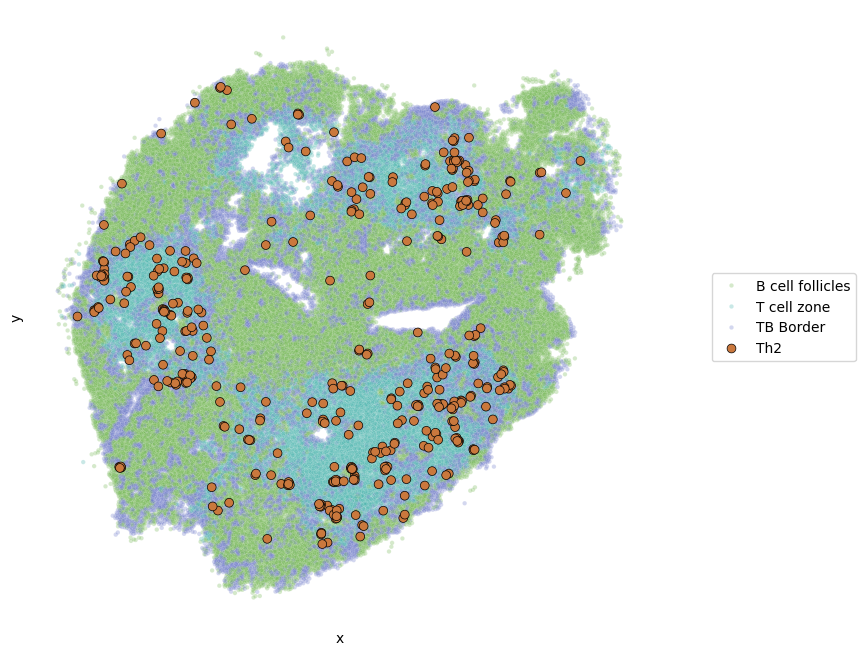

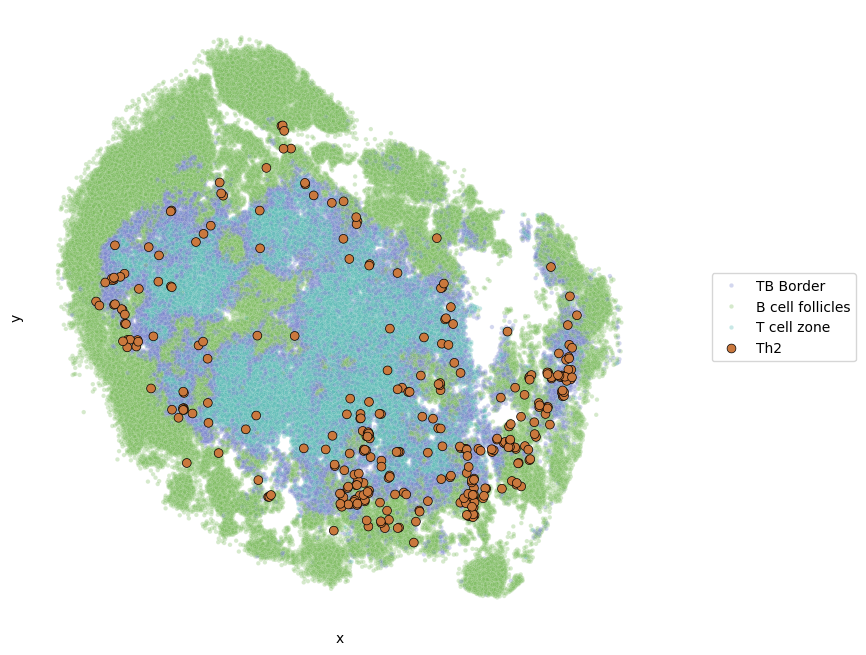

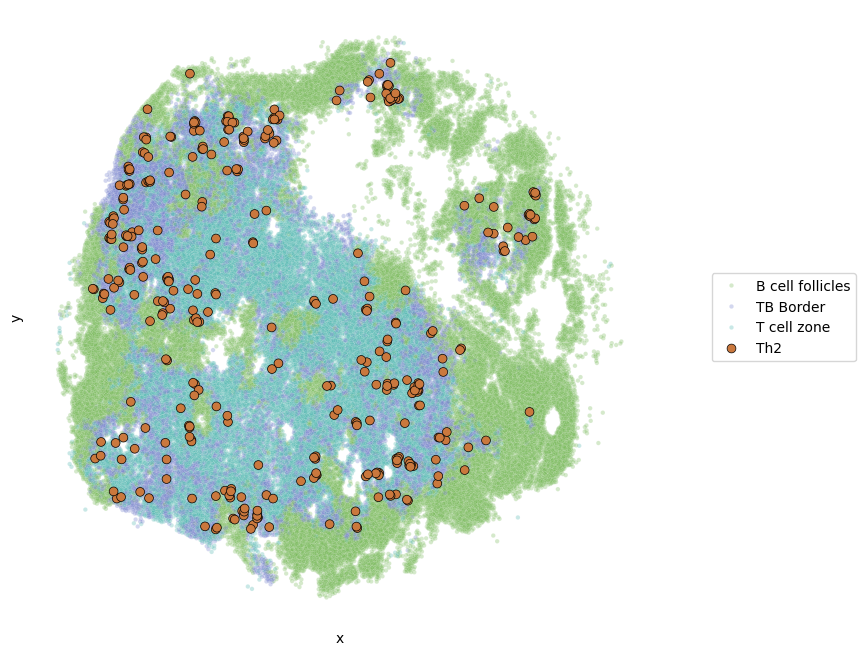

In [11]:
plot_spatial_zones(
    adata_control, 
    'figures/mouse_lymph1_1DER_locations.svg', th2=adata_control[adata_control.obs.cell_type == 'Th2'].obs_names
)
plot_spatial_zones(
    adata_ko, 
    'figures/mouse_lymphKO4_1DER_locations.svg', th2=adata_ko[adata_ko.obs.cell_type == 'Th2'].obs_names
)
plot_spatial_zones(
    adata_ko2, 
    'figures/mouse_lymphKO2_1DER_locations.svg', th2=adata_ko2[adata_ko2.obs.cell_type == 'Th2'].obs_names
)

In [ ]:
# plot_spatial_zones(
#     adata_control, adata_control.obs[adata_control.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
#     'figures/mouse_lymph1_1DER_locations.svg', th2=adata_control[adata_control.obs.cell_type == 'Th2'].obs_names
# )
# plot_spatial_zones(
#     adata_ko, adata_ko.obs[adata_ko.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
#     'figures/mouse_lymphKO4_1DER_locations.svg', th2=adata_ko[adata_ko.obs.cell_type == 'Th2'].obs_names
# )
# plot_spatial_zones(
#     adata_ko2, adata_ko2.obs[adata_ko2.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
#     'figures/mouse_lymphKO2_1DER_locations.svg', th2=adata_ko2[adata_ko2.obs.cell_type == 'Th2'].obs_names
# )

In [12]:
display(adata_control[adata_control.obs['cell_type'].isin(['Th2'])].obs['banksy_cluster'].value_counts())
display(adata_ko[adata_ko.obs['cell_type'].isin(['Th2'])].obs['banksy_cluster'].value_counts())
display(adata_ko2[adata_ko2.obs['cell_type'].isin(['Th2'])].obs['banksy_cluster'].value_counts())


banksy_cluster
T cell zone         188
TB Border           187
B cell follicles     58
Name: count, dtype: int64

banksy_cluster
TB Border           165
B cell follicles     87
T cell zone          80
Name: count, dtype: int64

banksy_cluster
T cell zone         229
TB Border            95
B cell follicles     40
Name: count, dtype: int64

In [13]:
# df_control = pd.concat([adata_control.to_df(), adata_control.obs[['cell_type', 'banksy_cluster']]], axis=1)
# df_ko = pd.concat([adata_ko.to_df(), adata_ko.obs[['cell_type', 'banksy_cluster']]], axis=1)
# df_ko2 = pd.concat([adata_ko2.to_df(), adata_ko2.obs[['cell_type', 'banksy_cluster']]], axis=1)

# df_control['tissue'] = 'control'
# df_ko['tissue'] = 'ko'
# df_ko2['tissue'] = 'ko2'

# df_all = pd.concat([df_control, df_ko, df_ko2], axis=0)
# zone_order = ['B cell follicles', 'TB Border', 'T cell zone']
# df_all['banksy_cluster'] = pd.Categorical(df_all['banksy_cluster'], categories=zone_order, ordered=True)
# df_melted = df_all.melt(
#     id_vars=['banksy_cluster', 'tissue'],
#     value_vars=['Ccl17', 'Ccl22', 'Ccl21a', 'Ccl5'],
#     var_name='Gene',
#     value_name='Expression'
# )

# genes = ['Ccl5', 'Ccl17', 'Ccl22']
# fig, axes = plt.subplots(1, len(genes), figsize=(16, 5), sharey=False)

# def add_significance(ax, x1, x2, y, p, h_rel=0.02, star_offset_rel=0.01):
#     y_min, y_max = ax.get_ylim()
#     y_range = y_max - y_min
#     h = h_rel * y_range
#     star_offset = star_offset_rel * y_range
#     ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c='k', clip_on=False)
#     if p < 0.001:
#         stars = '***'
#     elif p < 0.01:
#         stars = '**'
#     elif p < 0.05:
#         stars = '*'
#     else:
#         stars = 'ns'
#     ax.text((x1 + x2) * 0.5, y + h + star_offset, stars, ha='center', va='bottom', color='k', fontsize=9, clip_on=False)

# for i, gene in enumerate(genes):
#     ax = axes[i]
#     data_gene = df_melted[df_melted['Gene'] == gene]
#     # Compute mean expression per group (group by tissue, color by zone)
#     mean_df = (
#         data_gene
#         .groupby(['tissue', 'banksy_cluster'], observed=True)['Expression']
#         .mean()
#         # .sum()
#         .reset_index()
#     )
#     # Ensure banksy_cluster is categorical and sorted in the desired order
#     mean_df['banksy_cluster'] = pd.Categorical(mean_df['banksy_cluster'], categories=zone_order, ordered=True)
#     # Barplot of mean expression: x = tissue, hue = banksy_cluster (zone)
#     sns.barplot(
#         data=mean_df,
#         x='tissue',
#         y='Expression',
#         hue='banksy_cluster',
#         palette=color_dict,
#         ax=ax,
#         edgecolor='black',
#         linewidth=0.5,
#         dodge=True,
#         alpha=0.7,
#         hue_order=zone_order
#     )
#     # # Overlay stripplot of nonzero values
#     # sns.stripplot(
#     #     data=data_gene[data_gene['Expression'] > 0],
#     #     x='tissue',
#     #     y='Expression',
#     #     hue='banksy_cluster',
#     #     palette=color_dict,
#     #     dodge=True,
#     #     ax=ax,
#     #     size=2,
#     #     jitter=True,
#     #     marker='o',
#     #     linewidth=0,
#     #     alpha=0.5,
#     #     legend=False,
#     #     hue_order=zone_order
#     # )
#     ax.set_title(f'{gene} Expression')
#     ax.set_xlabel('Tissue')
#     if i == 0:
#         ax.set_ylabel('Expression')
#     else:
#         ax.set_ylabel('')

#     # Add significance bars for each tissue between zones
#     tissues = mean_df['tissue'].unique()
#     zones = zone_order  # Use the specified order
#     width = 0.8 / len(zones)  # width of each bar

#     # For each tissue, compare all pairs of zones
#     for j, tissue in enumerate(tissues):
#         tissue_data = data_gene[data_gene['tissue'] == tissue]
#         pairs = list(itertools.combinations(zones, 2))
#         # Find the max y for this tissue's bars
#         y_bars = mean_df[mean_df['tissue'] == tissue]['Expression'].values
#         if len(y_bars) == 0:
#             continue
#         y_max = np.max(y_bars)
#         # Set a small, fixed offset for annotation stacking, relative to y-range
#         y_min_ax, y_max_ax = ax.get_ylim()
#         y_range = y_max_ax - y_min_ax
#         y_offset = max(y_range * 0.05, 0.02 * y_range)
#         # For each pair, stack significance bars closely above the bars
#         for k, (zone1, zone2) in enumerate(pairs):
#             vals1 = tissue_data[tissue_data['banksy_cluster'] == zone1]['Expression']
#             vals2 = tissue_data[tissue_data['banksy_cluster'] == zone2]['Expression']
#             # Only test if both groups have >0 nonzero values
#             if (vals1 > 0).sum() > 0 or (vals2 > 0).sum() > 0:
#                 try:
#                     stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
#                 except ValueError:
#                     p = 1.0
#             else:
#                 p = 1.0
#             # Calculate x positions for bars
#             zone_idx1 = zones.index(zone1)
#             zone_idx2 = zones.index(zone2)
#             x1 = j - 0.4 + width/2 + zone_idx1*width
#             x2 = j - 0.4 + width/2 + zone_idx2*width
#             y = y_max + (k+1) * y_offset * 1.3
#             add_significance(ax, x1, x2, y, p, h_rel=0.01, star_offset_rel=0.005)

#     # Remove all legends from axes
#     ax.legend_.remove() if ax.get_legend() is not None else None

# # Move the legend below the subplots, off of the plot
# handles, labels = axes[-1].get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# legend_labels = [z for z in zone_order if z in by_label]
# legend_handles = [by_label[z] for z in legend_labels]
# fig.subplots_adjust(bottom=0.22)  # Make space for legend below
# fig.legend(
#     legend_handles,
#     legend_labels,
#     title='Zone',
#     loc='lower center',
#     bbox_to_anchor=(0.5, -0.08),
#     ncol=3,
#     frameon=False
# )

# plt.tight_layout()  # leave space at bottom for legend
# plt.savefig('figures/mouse_lymph_visiumHD_ligand_gradient.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')
# plt.show()

In [14]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Th2.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)

### KO localization prediction

In [15]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography

In [16]:
adata_ = adata_control[adata_control.obs.cell_type == 'Th2']
# adata_ = adata_control[(adata_control.obs.cell_type == 'Th2') & (adata_control.obs.index.isin(transferred))]
chart = Cartography(adata_, color_dict)

In [17]:
delta_X = (simulated_gex.loc[adata_.obs.index] - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
P = chart.compute_transition_probabilities(
    delta_X, 
    embedding=chart.adata.obsm['X_umap'],
    n_neighbors=130)

In [18]:
chart.get_transition_annot(
    P,
    allowed_fates=chart.adata.obs['banksy_cluster'].unique(), 
    thresh=0, 
    annot='banksy_cluster'
)

  4%|▎         | 7/188 [00:00<00:02, 62.79it/s]

100%|██████████| 188/188 [00:02<00:00, 70.08it/s]


source ct T cell zone Counter({'T cell zone': 114, 'TB Border': 68, 'B cell follicles': 6}) 0.000713626799007674 3.802972649212642e-05


100%|██████████| 187/187 [00:02<00:00, 82.85it/s]


source ct TB Border Counter({'TB Border': 171, 'B cell follicles': 13, 'T cell zone': 3}) 0.0005719419359524389 6.441239997462374e-05


100%|██████████| 58/58 [00:00<00:00, 85.99it/s]


source ct B cell follicles Counter({'B cell follicles': 46, 'TB Border': 11, 'T cell zone': 1}) 0.0012689579218730423 0.0


In [19]:
import plotly.graph_objects as go
import numba
numba.set_num_threads(1)

def plot_sankey_from_counts(df, counts, title, savepath, color_dict=None):
    counts = counts.sort_index(axis=0).sort_index(axis=1)

    left_labels = sorted(list(counts.index))
    right_labels = sorted(list(counts.columns))

    # Create unique node keys for left and right, but display the same label
    left_keys = [f"{label}__from" for label in left_labels]
    right_keys = [f"{label}__to" for label in right_labels]
    all_keys = left_keys + right_keys

    all_labels = left_labels + right_labels

    # Map from original label to unique key
    left_label_to_key = {label: f"{label}__from" for label in left_labels}
    right_label_to_key = {label: f"{label}__to" for label in right_labels}

    # Map unique keys to node indices
    left_key_to_idx = {key: i for i, key in enumerate(left_keys)}
    right_key_to_idx = {key: i + len(left_keys) for i, key in enumerate(right_keys)}
    key_to_idx = {**left_key_to_idx, **right_key_to_idx}

    # Node colors
    if color_dict is not None:
        node_colors = [color_dict.get(label, "#1f77b4") for label in all_labels]
    else:
        node_colors = "blue"

    sources = []
    targets = []
    values = []
    link_colors = []

    for src in left_labels:
        for tgt in right_labels:
            val = counts.loc[src, tgt] if (src in counts.index and tgt in counts.columns) else 0
            if val > 0:
                src_key = left_label_to_key[src]
                tgt_key = right_label_to_key[tgt]
                sources.append(key_to_idx[src_key])
                targets.append(key_to_idx[tgt_key])
                values.append(val)
                # Use color_dict for link color if available, else default rgba
                if color_dict is not None:
                    base_color = color_dict.get(src, "#1f77b4")
                    if base_color.startswith("#") and len(base_color) == 7:
                        r = int(base_color[1:3], 16)
                        g = int(base_color[3:5], 16)
                        b = int(base_color[5:7], 16)
                        link_colors.append(f"rgba({r},{g},{b},0.4)")
                    else:
                        link_colors.append("rgba(31,119,180,0.4)")
                else:
                    link_colors.append("rgba(31,119,180,0.4)")

    # Set node x positions: left column at 0, right column at 1
    node_x = [0.0] * len(left_keys) + [1.0] * len(right_keys)

    fig = go.Figure(data=[go.Sankey(
        # arrangement="snap",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color=node_colors,
            x=node_x,
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text=title,
        font_size=10,
        autosize=False,
        width=500,
        height=400,
        margin=dict(l=10, r=10, t=40, b=10)
    )

    fig.write_image(savepath, format=savepath.split('.')[-1], engine='orca')
    fig.show()

In [20]:
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].astype('category')
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

df = chart.adata.obs[['banksy_cluster', 'transition']].copy()
counts = df.groupby(['banksy_cluster', 'transition']).size().unstack(fill_value=0)

plot_sankey_from_counts(
    df, counts, 
    # In Plotly, line breaks in titles using '\n' are not always rendered as new lines.
    # To achieve a line break in a Plotly title, use '<br>' instead of '\n'.
    "Th2 Transitions between zones from Ccr4 KO<br>in Day 5 VisiumHD Mouse Lymph Node", 
    f'figures/mouse_lymph1_{goi}KO_transitions_Th2.svg', 
    color_dict=color_dict
)

# if counts.empty:
#     # Create empty DataFrame with same index and columns
#     counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
# elif len(counts.index) != len(counts.columns):
#     # Add missing rows/columns with zeros
#     all_labels = sorted(set(counts.index) | set(counts.columns))
#     counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

# plt.figure(figsize=(3,3), dpi=300)
# sns.heatmap(
#     counts,
#     annot=True,
#     fmt='d',  # Changed to integer format
#     cmap='Blues',
#     linewidths=0.5,
#     linecolor='white',
#     cbar=False,
#     square=True,
#     annot_kws={"size": 6}
# )

# plt.title(f"Th2 Transitions between zones from Ccr4 KO\nin Day 5 VisiumHD Mouse Lymph Node", fontsize=8)
# plt.xlabel("Transition Label", fontsize=6)
# plt.ylabel("Original", fontsize=6)
# plt.xticks(rotation=45, ha='right', fontsize=6)
# plt.yticks(rotation=0, fontsize=6)

# plt.tight_layout()
# plt.savefig(f'figures/mouse_lymph1_{goi}KO_transitions_Th2.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
# plt.show()

Retrying in 8.20 seconds due to HTTPConnectionPool(host='localhost', port=46579): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fda2462c6a0>: Failed to establish a new connection: [Errno 111] Connection refused'))...
Retrying in 5.13 seconds due to HTTPConnectionPool(host='localhost', port=46579): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fda2462c370>: Failed to establish a new connection: [Errno 111] Connection refused'))...


### Altered interactions?

In [21]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Th2.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex = simulated_gex.loc[adata_control.obs.index]

In [22]:
def compute_delta_ko_zone(gex_ko, adata_ko, adata_control, epsilon=1e-8):
    delta_ko_zone = {}
    for zone in adata_ko.obs['banksy_cluster'].unique():
        gex_ko_zone = gex_ko[adata_ko.obs['banksy_cluster'] == zone]
        control_zone = adata_control[adata_control.obs['banksy_cluster'] == zone].to_df(layer='normalized_count').mean(axis=0)
        delta_ko_zone[zone] = ((gex_ko_zone.mean(axis=0) - control_zone) / (control_zone + epsilon)).abs().mean()
    return delta_ko_zone

def plot_delta_zone_barplot(delta_zone, color_dict, title, save_path='figures/mouse_lymph1_Ccr4KO_delta_zone_barplot.svg'):
    fig, ax = plt.subplots(figsize=(5, 5))

    # Convert the dictionary to a DataFrame
    delta_zone_df = pd.DataFrame(list(delta_zone.items()), columns=['banksy_cluster', 'Mean Relative Change'])

    order = ['B cell follicles', 'TB Border', 'T cell zone']
    delta_zone_df['banksy_cluster'] = pd.Categorical(delta_zone_df['banksy_cluster'], categories=order, ordered=True)

    sns.barplot(
        data=delta_zone_df,
        x='banksy_cluster',
        y='Mean Relative Change',
        ax=ax,
        palette=color_dict,
        edgecolor='black'
    )

    ax.set_ylabel('Mean Relative Change', fontsize=10)
    ax.set_xlabel('banksy_cluster', fontsize=10)
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='x', labelrotation=30, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)


    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 3), textcoords='offset points')
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max + 5)

    plt.tight_layout()
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()



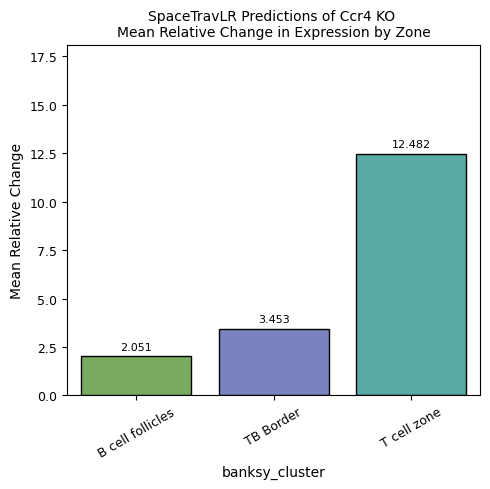

In [23]:
delta_zone = compute_delta_ko_zone(simulated_gex, adata_control, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='SpaceTravLR Predictions of Ccr4 KO \nMean Relative Change in Expression by Zone',
                        save_path='figures/mouse_lymph1_Ccr4KO_delta_zone_barplot.svg')

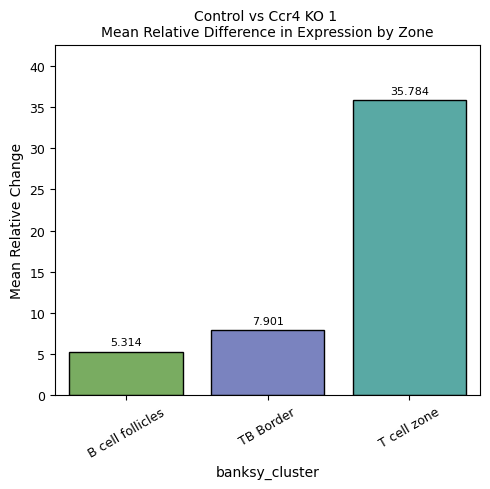

In [24]:
delta_zone = compute_delta_ko_zone(adata_ko.to_df(layer='normalized_count'), adata_ko, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='Control vs Ccr4 KO 1 \nMean Relative Difference in Expression by Zone',
                        save_path='figures/mouse_lymphKO4_Ccr4KO_delta_zone_barplot.svg')

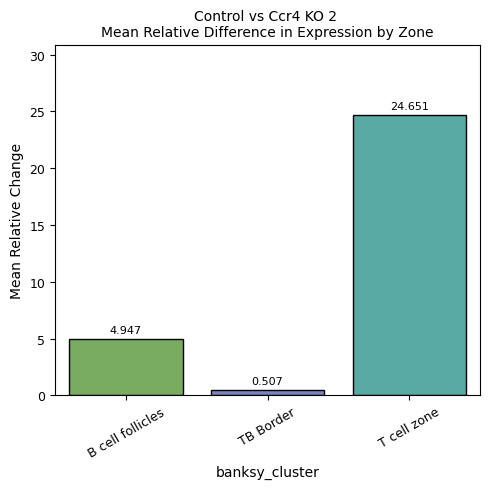

In [25]:
delta_zone = compute_delta_ko_zone(adata_ko2.to_df(layer='normalized_count'), adata_ko2, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='Control vs Ccr4 KO 2 \nMean Relative Difference in Expression by Zone',
                        save_path='figures/mouse_lymphKO2_Ccr4KO_delta_zone_barplot.svg')

### Correlation of Th2 Environments to experimental data

In [26]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Th2.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex = simulated_gex.loc[adata_control.obs.index]

# adata_control.layers['simulated_count'] = simulated_gex

delta_gex = simulated_gex - adata_control.to_df(layer='imputed_count')
gex_sim = adata_control.to_df(layer='normalized_count') + delta_gex
adata_control.layers['simulated_count'] = gex_sim


In [27]:
from scipy.spatial import cKDTree

def get_b_neighbors(adata, radius=30, use_1der=False, neighbor_type='CD8+ T'):

    b_idx = adata.obs_names[adata.obs['cell_type'] == neighbor_type]
    b_coords = adata[adata.obs['cell_type'] == neighbor_type].obsm['spatial']

    if use_1der:
        t_idx = adata.obs_names[adata.obs['1DER_cell_type'] == '1DER Th2']
        t_coords = adata[adata.obs['1DER_cell_type'] == '1DER Th2'].obsm['spatial']
    else:
        t_idx = adata.obs_names[adata.obs['cell_type'] == 'Th2']
        t_coords = adata[adata.obs['cell_type'] == 'Th2'].obsm['spatial']
        

    b_tree = cKDTree(b_coords)

    b_near_t = {}
    for i, (t_name, t_coord) in enumerate(zip(t_idx, t_coords)):
        idxs = b_tree.query_ball_point(t_coord, r=radius)
        b_near_t[t_name] = list(b_idx[idxs])

    return b_near_t

def make_environmental_adata(b_near_t, adata, layer='normalized_count'):
    b_neighbors = {}
    gex_df = adata.to_df(layer=layer)
    for cell, gex in b_near_t.items():
        b_neighbors[cell] = gex_df.loc[b_near_t[cell]].mean()

    b_neighbors = pd.DataFrame(b_neighbors).T

    b_neighbors = sc.AnnData(
        X = b_neighbors.values,
        obs = adata.obs.loc[b_neighbors.index],
        var = pd.DataFrame(index=b_neighbors.columns)
    )
    b_neighbors.X = np.nan_to_num(b_neighbors.X, nan=0)

    return b_neighbors

In [28]:
control_neighbors = get_b_neighbors(adata_control, neighbor_type='CD8+ T')
cd8_control = make_environmental_adata(control_neighbors, adata_control, layer='normalized_count')
cd8_simulated = make_environmental_adata(control_neighbors, adata_control, layer='simulated_count')
cd8_simulated.obs['tissue'] = 'simulated'

ko_neighbors = get_b_neighbors(adata_ko, neighbor_type='CD8+ T')
cd8_ko = make_environmental_adata(ko_neighbors, adata_ko, layer='normalized_count')

ko2_neighbors = get_b_neighbors(adata_ko2, neighbor_type='CD8+ T')
cd8_ko2 = make_environmental_adata(ko2_neighbors, adata_ko2, layer='normalized_count')

In [29]:
sim_adata = sc.concat([cd8_control, cd8_simulated, cd8_ko, cd8_ko2], axis=0)
sim_adata

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



AnnData object with n_obs × n_vars = 1562 × 2116
    obs: 'cell_type', 'secondary_annot', 'banksy_cluster', 'tissue', '1DER_cell_type'

In [30]:
baseline_adata = sc.concat([
    adata_control[adata_control.obs['cell_type'] == 'CD8+ T'], 
    adata_ko[adata_ko.obs['cell_type'] == 'CD8+ T'], 
    adata_ko2[adata_ko2.obs['cell_type'] == 'CD8+ T']
], axis=0)

sc.tl.rank_genes_groups(baseline_adata, groupby='tissue', method='wilcoxon', reference='lymph1', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(baseline_adata, group='lymphKO4')
degs_df2 = sc.get.rank_genes_groups_df(baseline_adata, group='lymphKO2')

degs_consistent = pd.merge(degs_df, degs_df2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
degs_consistent['min_pval'] = degs_consistent[['pvals_ko2', 'pvals_ko4']].min(axis=1)
degs_consistent['avg_lfc'] = (degs_consistent['logfoldchanges_ko2'] + degs_consistent['logfoldchanges_ko4']) / 2
baseline_degs_copy = degs_consistent.copy()

degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]

degs_consistent = degs_consistent[degs_consistent['avg_lfc'].abs() > 0.5]
degs_consistent = degs_consistent[degs_consistent['min_pval'] < 0.05]
degs_consistent.sort_values(by='avg_lfc', ascending=False, inplace=True, key=abs)

discard_genes = degs_consistent['names'].values
len(discard_genes)

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



104

In [31]:
from functools import reduce

sc.tl.rank_genes_groups(sim_adata, groupby='tissue', method='wilcoxon', reference='lymph1', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO4')
degs_df2 = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO2')
degs_sim = sc.get.rank_genes_groups_df(sim_adata, group='simulated')

degs_consistent = pd.merge(degs_df, degs_df2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]

degs_consistent['min_pval'] = degs_consistent[['pvals_ko2', 'pvals_ko4']].min(axis=1)
degs_consistent['avg_lfc'] = (degs_consistent['logfoldchanges_ko2'] + degs_consistent['logfoldchanges_ko4']) / 2
degs_consistent = degs_consistent[degs_consistent['avg_lfc'].abs() > 0.5]
degs_consistent = degs_consistent[degs_consistent['min_pval'] < 0.05]
degs_consistent.sort_values(by='avg_lfc', ascending=False, inplace=True, key=abs)
degs_consistent.shape

(239, 11)

In [32]:
# Remove genes not specific to Th2 environment
degs_consistent = degs_consistent[~degs_consistent['names'].isin(discard_genes)]
degs_consistent.shape

(184, 11)

In [33]:
degs_consistent['logfoldchanges_sim'] = cd8_simulated.to_df().mean(axis=0)[degs_consistent['names']].values
xvals = degs_consistent['logfoldchanges_sim']
yvals = degs_consistent['avg_lfc']

r, pval = spearmanr(xvals, yvals)
print('CD8+ T Correlation: ', r, pval)
r, pval = pearsonr(xvals, yvals)
print('CD8+ T Correlation: ', r, pval)


CD8+ T Correlation:  0.43819614339927954 4.941654321882927e-10
CD8+ T Correlation:  0.19046169230485105 0.009606193016727082


In [34]:
degs_consistent['baseline_lfc'] = baseline_degs_copy.set_index('names').loc[degs_consistent['names'], 'avg_lfc'].values

xvals = degs_consistent['baseline_lfc']
yvals = degs_consistent['avg_lfc']
r, pval = spearmanr(xvals, yvals)
print('Baseline CD8+ T Correlation: ', r, pval)

Baseline CD8+ T Correlation:  0.233628710677891 0.0014139620811589836


CD8+ T Spearman Correlation:  0.43819614339927954 4.941654321882927e-10
Baseline Spearman Correlation:  0.233628710677891 0.0014139620811589836


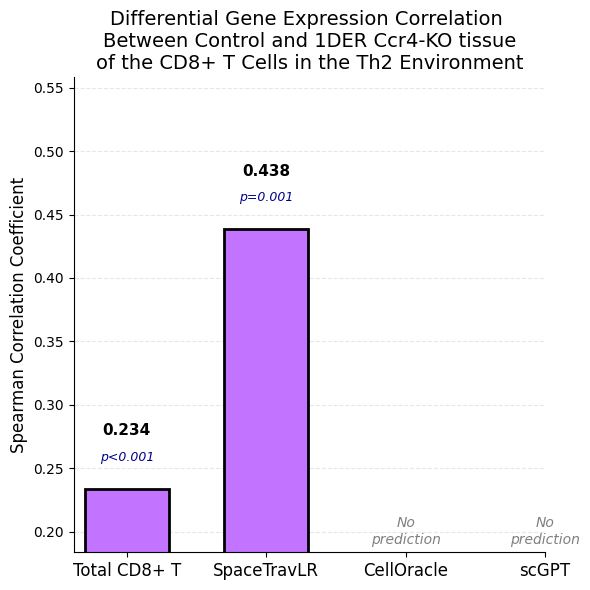

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Your correlation calculations
# CD8+ T correlation
degs_consistent['logfoldchanges_sim'] = cd8_simulated.to_df().mean(axis=0)[degs_consistent['names']].values
xvals = degs_consistent['logfoldchanges_sim']
yvals = degs_consistent['avg_lfc']

r_spearman_cd8, pval_spearman_cd8 = spearmanr(xvals, yvals)
print('CD8+ T Spearman Correlation: ', r_spearman_cd8, pval_spearman_cd8)

# Baseline correlation
degs_consistent['baseline_lfc'] = baseline_degs_copy.set_index('names').loc[degs_consistent['names'], 'avg_lfc'].values
xvals_baseline = degs_consistent['baseline_lfc']
yvals_baseline = degs_consistent['avg_lfc']

r_spearman_baseline, pval_spearman_baseline = spearmanr(xvals_baseline, yvals_baseline)
print('Baseline Spearman Correlation: ', r_spearman_baseline, pval_spearman_baseline)

# Create single bar plot for Spearman correlation
fig, ax = plt.subplots(figsize=(6, 6))

# X-axis categories
categories = ['Total CD8+ T', 'SpaceTravLR', 'CellOracle', 'scGPT']
x_pos = np.arange(len(categories))

# Bar width
bar_width = 0.6

# Spearman correlation values (np.nan for methods that cannot predict)
spearman_values = [r_spearman_baseline, r_spearman_cd8, np.nan, np.nan]

# Colors
spearman_color = '#c273ff'
edge_color = 'black'

# Create mask for bars with actual values
spearman_mask = ~np.isnan(spearman_values)

# Create bars only for non-NaN values
bars = ax.bar(x_pos[spearman_mask], 
              np.array(spearman_values)[spearman_mask], bar_width,
              color=spearman_color, edgecolor=edge_color, linewidth=2)

# Customize the plot
ax.set_ylabel('Spearman Correlation Coefficient', fontsize=12)
ax.set_title('Differential Gene Expression Correlation \n'
             + 'Between Control and 1DER Ccr4-KO tissue\nof the CD8+ T Cells in the Th2 Environment', 
             fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=12)

# Add value labels on bars and "No prediction" text
for i, (pos, value) in enumerate(zip(x_pos, spearman_values)):
    if not np.isnan(value):
        # Get corresponding p-value
        pval = pval_spearman_cd8 if i == 0 else pval_spearman_baseline
        
        # Format p-value for display
        if pval < 0.001:
            pval_str = f"p<0.001"
        else:
            pval_str = f"p={pval:.3f}"
        
        # Add correlation coefficient
        ax.text(pos, value + 0.04, f'{value:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
        
        # Add p-value below the correlation coefficient
        ax.text(pos, value + 0.02, pval_str, ha='center', va='bottom', 
                fontsize=9, color='darkblue', style='italic')
    else:
        # Add "No prediction" text for NaN values
        y_text_pos = 0.8 if ax.get_ylim()[1] > 1 else 0.2
        ax.text(pos, y_text_pos, 'No\nprediction', 
                ha='center', va='center', color='gray', 
                fontsize=10, fontstyle='italic')

# Set y-axis limits with some padding (extra space for p-values)
valid_values = [v for v in spearman_values if not np.isnan(v)]
if valid_values:
    y_min = min(valid_values) - 0.05
    y_max = max(valid_values) + 0.12  # Extra space for correlation + p-value text
else:
    y_min, y_max = 0, 1
ax.set_ylim(y_min, y_max)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()

plt.savefig('figures/correlation_comparison.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [130]:
import squidpy as sq

cd8_adata = adata_control[adata_control.obs['cell_type'] == 'CD8+ T']

selected_degs = degs_consistent
sq.gr.spatial_neighbors(cd8_adata)
moran = sq.gr.spatial_autocorr(cd8_adata, mode='moran', genes=selected_degs['names'].values, n_perms=100, copy=True)

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


  0%|          | 0/100 [00:00<?, ?/s]

In [131]:
moran.sort_values(by='I', ascending=False, inplace=True, key=abs)
moran.head(30)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Ccl21a,0.173219,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000026,0.000000e+00,0.000000e+00,0.029384
Lyz2,0.137920,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000029,0.000000e+00,0.000000e+00,0.029384
Apoe,0.133102,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000027,0.000000e+00,0.000000e+00,0.029384
C3,0.115141,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000029,0.000000e+00,0.000000e+00,0.029384
Clu,0.112059,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000023,0.000000e+00,0.000000e+00,0.029384
Fn1,0.080216,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000023,0.000000e+00,0.000000e+00,0.029384
Vim,0.058193,0.000000e+00,0.000033,0.000000e+00,0.009901,0.000019,0.000000e+00,0.000000e+00,0.029384
Trac,0.044695,2.553513e-15,0.000033,0.000000e+00,0.009901,0.000024,5.873080e-14,0.000000e+00,0.029384
Mki67,0.040835,4.267697e-13,0.000033,0.000000e+00,0.009901,0.000019,8.725070e-12,0.000000e+00,0.029384
Icos,0.039544,2.153500e-12,0.000033,0.000000e+00,0.009901,0.000017,3.962439e-11,0.000000e+00,0.029384


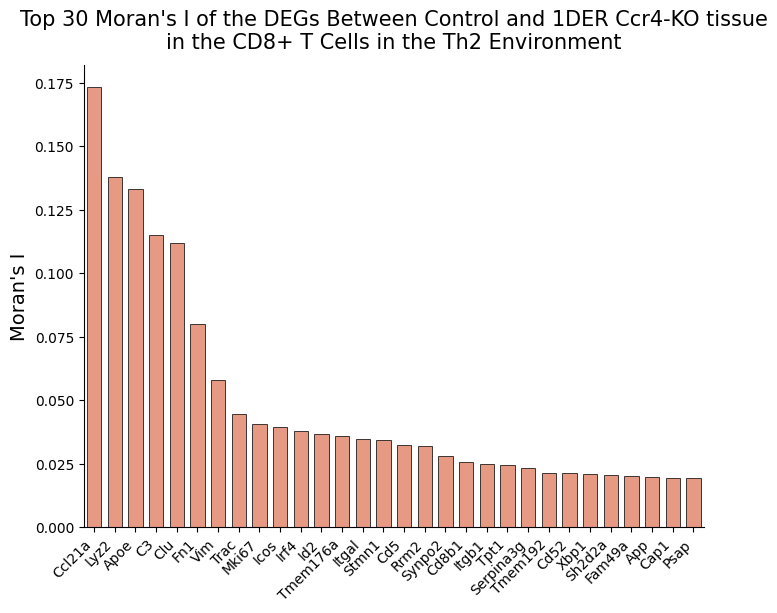

In [132]:
bar_kwargs = dict(width=0.7, edgecolor='k', linewidth=0.7)

moran = moran.head(30)

x = np.arange(len(moran.index))
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=x, y=moran['I'].values, color='#f46d43', alpha=0.75, **bar_kwargs)
ax.set_xticks(x)
ax.set_xticklabels(moran.index, rotation=45, ha='right')
ax.set_ylabel("Moran's I", fontsize=14)
ax.set_title("Top 30 Moran's I of the DEGs Between Control and 1DER Ccr4-KO tissue\nin the CD8+ T Cells in the Th2 Environment", fontsize=15, pad=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will return nan for these.
  warnings.warn(
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/scanpy/metrics/_common.py:62: UserWarning: 4 variables were constant, will r

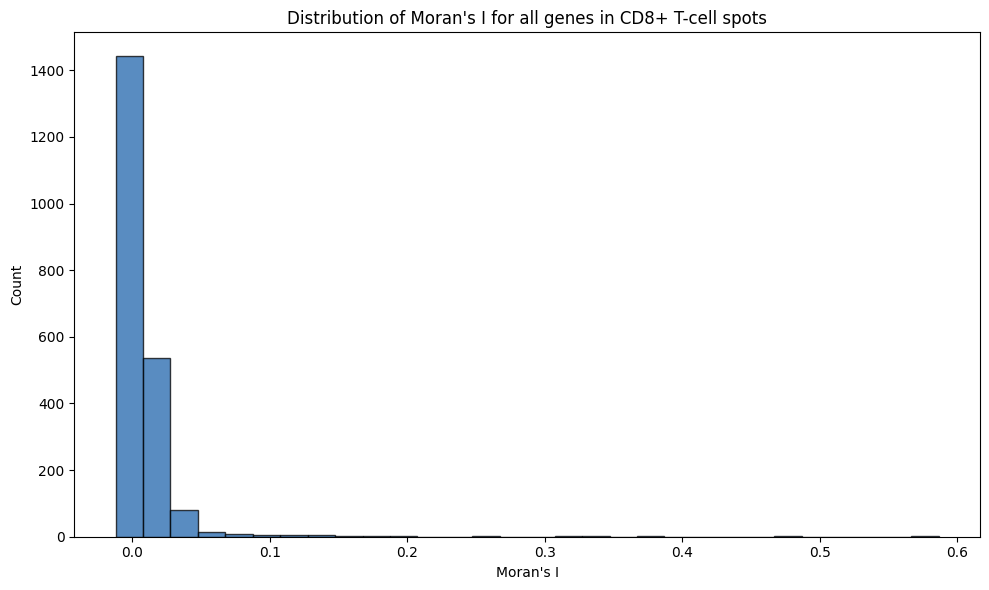

In [129]:
import squidpy as sq

sq.gr.spatial_neighbors(cd8_adata)
baseline = sq.gr.spatial_autocorr(cd8_adata, mode='moran', genes=cd8_adata.var_names, n_perms=100, copy=True)

plt.figure(figsize=(10, 6))
plt.hist(baseline['I'], bins=30, color='#2166ac', alpha=0.75, edgecolor='k')
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.title("Distribution of Moran's I for all genes in CD8+ T-cell spots")
plt.tight_layout()
plt.show()

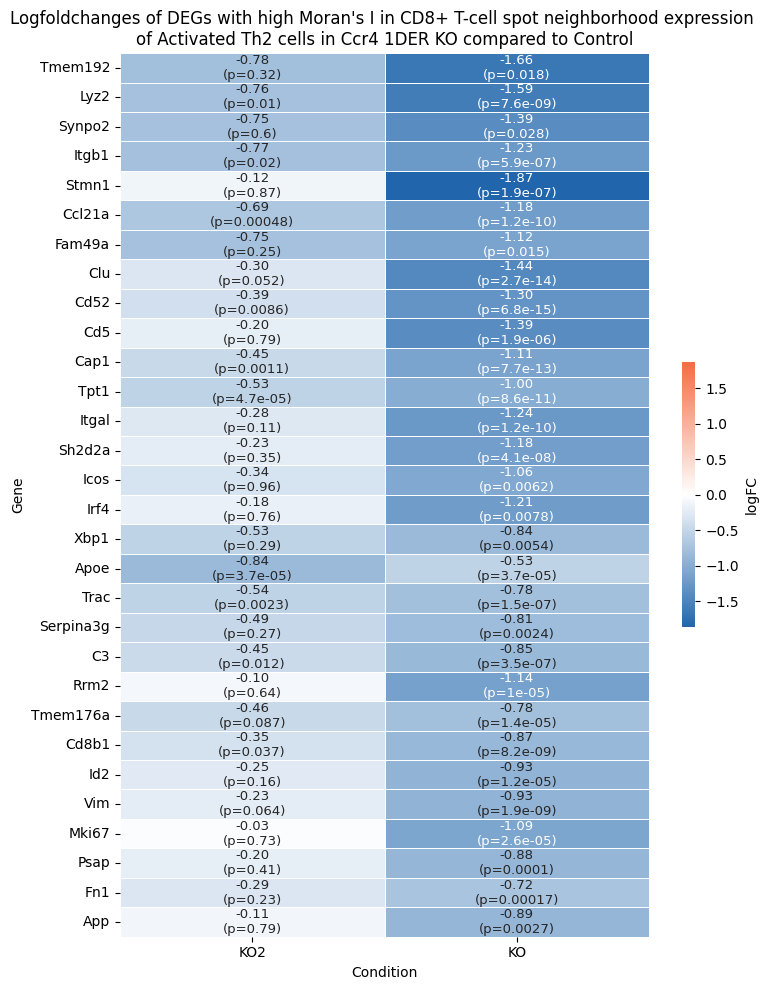

In [126]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a blue-white-orange colormap
blue_orange_cmap = LinearSegmentedColormap.from_list(
    'blue_orange', 
    ['#2166ac', 'white', '#f46d43']  # blue → white → orange
)

# selected_degs = pd.concat([
#     degs_consistent[degs_consistent['avg_lfc'] > 0].sort_values(by='avg_lfc', ascending=False).head(30),
#     degs_consistent[degs_consistent['avg_lfc'] < 0].sort_values(by='avg_lfc', ascending=True).head(30)
# ])

selected_degs = degs_consistent[degs_consistent['names'].isin(moran.head(30).index)]

relabel = {
    'logfoldchanges_ko2': 'KO2',
    'logfoldchanges_ko4': 'KO',
}

# Prepare heatmap data for logfoldchanges
heatmap_data = selected_degs.set_index('names')[['logfoldchanges_ko2', 'logfoldchanges_ko4']]
heatmap_data.columns = [relabel.get(col, col) for col in heatmap_data.columns]

# Prepare annotation data with logfoldchange
def make_annot(row):
    return [
        f"{row['logfoldchanges_ko2']:.2f}",
        f"{row['logfoldchanges_ko4']:.2f}",
    ]

annot_data = selected_degs.apply(make_annot, axis=1, result_type='expand')
annot_data.index = selected_degs['names']
annot_data.columns = heatmap_data.columns

# Calculate max value for color scaling
max_abs = np.abs(heatmap_data.values).max()
vmax = min(max_abs, 10)

# Create the heatmap with the custom colormap
plt.figure(figsize=(8, 10))
sns.heatmap(
    heatmap_data,
    annot=np.array([
        [f"{row['logfoldchanges_ko2']:.2f}\n(p={row['pvals_ko2']:.2g})", f"{row['logfoldchanges_ko4']:.2f}\n(p={row['pvals_ko4']:.2g})"]
        for _, row in selected_degs.iterrows()
    ]),
    annot_kws={"size":9.5},
    fmt='',
    cmap=blue_orange_cmap,  # Use the custom colormap
    center=0,
    linewidths=0.5,
    vmin=-vmax,
    vmax=vmax,
    cbar_kws={'label': 'logFC', 'shrink': 0.3},
)

# Add labels and title
plt.xlabel('Condition')
plt.ylabel('Gene')
plt.title('Logfoldchanges of DEGs with high Moran\'s I in CD8+ T-cell spot neighborhood expression \nof Activated Th2 cells in Ccr4 1DER KO compared to Control')

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/cd8_neighborhood_expression_1der_vs_polyclonal_th2.svg', dpi=300, transparent=True, bbox_inches='tight', format='svg')
plt.show()


In [489]:
control_neighbors = get_b_neighbors(adata_control, neighbor_type='B')
cd8_control = make_environmental_adata(control_neighbors, adata_control, layer='normalized_count')
cd8_simulated = make_environmental_adata(control_neighbors, adata_control, layer='simulated_count')
cd8_simulated.obs['tissue'] = 'simulated'

ko_neighbors = get_b_neighbors(adata_ko, neighbor_type='B')
cd8_ko = make_environmental_adata(ko_neighbors, adata_ko, layer='normalized_count')
ko2_neighbors = get_b_neighbors(adata_ko2, neighbor_type='B')
cd8_ko2 = make_environmental_adata(ko2_neighbors, adata_ko2, layer='normalized_count')

# Do the baseline analysis for B cells
baseline_adata = sc.concat([
    adata_control[adata_control.obs['cell_type'] == 'B'], 
    adata_ko[adata_ko.obs['cell_type'] == 'B'], 
    adata_ko2[adata_ko2.obs['cell_type'] == 'B']
], axis=0)

sc.tl.rank_genes_groups(baseline_adata, groupby='tissue', method='wilcoxon', reference='lymph1', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(baseline_adata, group='lymphKO4')
degs_df2 = sc.get.rank_genes_groups_df(baseline_adata, group='lymphKO2')

degs_consistent = pd.merge(degs_df, degs_df2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]

degs_consistent['min_pval'] = degs_consistent[['pvals_ko2', 'pvals_ko4']].min(axis=1)
degs_consistent['avg_lfc'] = (degs_consistent['logfoldchanges_ko2'] + degs_consistent['logfoldchanges_ko4']) / 2
degs_consistent = degs_consistent[degs_consistent['avg_lfc'].abs() > 0.5]
degs_consistent = degs_consistent[degs_consistent['min_pval'] < 0.05]
degs_consistent.sort_values(by='avg_lfc', ascending=False, inplace=True, key=abs)
discard_genes = degs_consistent['names'].values
# end baseline analysis for B cells


sim_adata = sc.concat([cd8_control, cd8_simulated, cd8_ko, cd8_ko2], axis=0)
from functools import reduce

sc.tl.rank_genes_groups(sim_adata, groupby='tissue', method='wilcoxon', reference='lymph1')
degs_df = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO4')
degs_df2 = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO2')
degs_sim = sc.get.rank_genes_groups_df(sim_adata, group='simulated')

degs_consistent = pd.merge(degs_df, degs_df2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]

degs_consistent['min_pval'] = degs_consistent[['pvals_ko2', 'pvals_ko4']].min(axis=1)
degs_consistent['avg_lfc'] = (degs_consistent['logfoldchanges_ko2'] + degs_consistent['logfoldchanges_ko4']) / 2
degs_consistent = degs_consistent[degs_consistent['avg_lfc'].abs() > 0.5]
degs_consistent = degs_consistent[degs_consistent['min_pval'] < 0.05]
degs_consistent.sort_values(by='avg_lfc', ascending=False, inplace=True, key=abs)

# Remove genes not specific to Th2 environment
degs_consistent = degs_consistent[~degs_consistent['names'].isin(discard_genes)]

degs_consistent['logfoldchanges_sim'] = cd8_simulated.to_df().mean(axis=0)[degs_consistent['names']].values
xvals = degs_consistent['logfoldchanges_sim']
yvals = degs_consistent['avg_lfc']

r, pval = spearmanr(xvals, yvals)
print('B Correlation: ', r, pval)
r, pval = pearsonr(xvals, yvals)
print('B Correlation: ', r, pval)

: 

In [487]:
degs_consistent[~degs_consistent['names'].isin(discard_genes)]

,names,scores_ko4,logfoldchanges_ko4,pvals_ko4,pvals_adj_ko4,scores_ko2,logfoldchanges_ko2,pvals_ko2,pvals_adj_ko2,min_pval,avg_lfc,logfoldchanges_sim
111,Fam89a,1.353795,3.428751,0.175802,0.566204,2.426897,3.464527,0.015229,0.052396,0.015229,3.446639,0.001101
208,Neb,0.712715,2.020571,0.476022,0.919035,2.564195,2.845016,0.010342,0.038273,0.010342,2.432793,0.001563
402,Lgals7,0.298753,1.559448,0.765129,0.999490,2.125736,3.022887,0.033525,0.098939,0.033525,2.291167,0.001102
1813,St6galnac3,-1.962525,-1.968404,0.049701,0.285783,-1.613916,-1.668936,0.106546,0.245322,0.049701,-1.818670,0.021908
61,Dnah8,2.013362,1.531331,0.044077,0.265924,3.613472,1.722358,0.000302,0.001864,0.000302,1.626845,0.008202
...,...,...,...,...,...,...,...,...,...,...,...,...
742,Itpripl2,-0.071965,0.489343,0.942630,0.999490,2.323421,0.561141,0.020157,0.064676,0.020157,0.525242,0.015827
298,Etfbkmt,0.475198,0.335596,0.634646,0.991993,2.143651,0.693118,0.032061,0.095148,0.032061,0.514357,0.015880
1859,Mocs2,-2.139300,-0.925435,0.032411,0.219113,0.499773,-0.096256,0.617235,0.838446,0.032411,-0.510845,0.019615
170,Relt,0.987865,0.478976,0.323219,0.758239,3.044818,0.542377,0.002328,0.010972,0.002328,0.510677,0.022063


In [24]:
cd8_control = adata_control[adata_control.obs.cell_type == 'Th2']
cd8_control.X = cd8_control.to_df(layer='normalized_count').values
cd8_simulated = adata_control[adata_control.obs.cell_type == 'Th2']
cd8_simulated.X = cd8_simulated.to_df(layer='simulated_count').values
cd8_simulated.obs['tissue'] = 'simulated'


cd8_ko = adata_ko[adata_ko.obs.cell_type == 'Th2']
cd8_ko.X = cd8_ko.to_df(layer='normalized_count').values
cd8_ko2 = adata_ko2[adata_ko2.obs.cell_type == 'Th2']
cd8_ko2.X = cd8_ko2.to_df(layer='normalized_count').values


sim_adata = sc.concat([cd8_control, cd8_simulated, cd8_ko, cd8_ko2], axis=0)
from functools import reduce

sc.tl.rank_genes_groups(sim_adata, groupby='tissue', method='wilcoxon', reference='lymph1', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO4')
degs_df2 = sc.get.rank_genes_groups_df(sim_adata, group='lymphKO2')
degs_sim = sc.get.rank_genes_groups_df(sim_adata, group='simulated')

degs_consistent = pd.merge(degs_df, degs_df2, on='names', how='inner', suffixes=('_ko4', '_ko2'))
degs_consistent = degs_consistent[degs_consistent['logfoldchanges_ko4'] * degs_consistent['logfoldchanges_ko2'] > 0]

degs_consistent['min_pval'] = degs_consistent[['pvals_ko2', 'pvals_ko4']].min(axis=1)
degs_consistent['avg_lfc'] = (degs_consistent['logfoldchanges_ko2'] + degs_consistent['logfoldchanges_ko4']) / 2
degs_consistent = degs_consistent[degs_consistent['avg_lfc'].abs() > 0.5]
degs_consistent = degs_consistent[degs_consistent['min_pval'] < 0.1]
degs_consistent.sort_values(by='avg_lfc', ascending=False, inplace=True, key=abs)

degs_consistent['logfoldchanges_sim'] = cd8_simulated.to_df().mean(axis=0)[degs_consistent['names']].values
xvals = degs_consistent['logfoldchanges_sim']
yvals = degs_consistent['avg_lfc']

r, pval = spearmanr(xvals, yvals)
print('Th2 Correlation: ', r, pval)
r, pval = pearsonr(xvals, yvals)
print('Th2 Correlation: ', r, pval)


/tmp/ipykernel_1720000/4094937567.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cd8_simulated.obs['tissue'] = 'simulated'
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Th2 Correlation:  -0.21997731883849428 5.110337652844257e-07
Th2 Correlation:  0.0170501436022497 0.7006020878462934
